## Dependencies

In [144]:
import time
import pickle
import numpy as np
import pandas as pd
import metric_learn
from matplotlib import style
from collections import Counter
import matplotlib.pyplot as plt

style.use('ggplot')

## Embeddings summary

In [128]:
## Embedding created from type of data (binary or normalized) 
type_dict ={'b':'Binary', 'n' : 'Normalized'}
emb_type = 'b' # b: binary; n: normalized 
emb_dim = 197 # emb dimension 197 or 99

## Import the embeddings
path = 'data/embeddings_{}_{}.npy'.format(emb_dim, emb_type)
emb = np.load(path)

print('{} embeddings loaded'.format(type_dict[emb_type]))
print("Embeddings are of the shape {}".format(emb.shape))
print("Column {} is the labels corresponding to each embedding".format(emb.shape[1]))

Binary embeddings loaded
Embeddings are of the shape (70000, 197)
Column 197 is the labels corresponding to each embedding


# Vanilla KNN on Embeddings

In [129]:
"""
## To-Do
- Try the same on the only the MNIST datasets

- Decide on k values
- Calculate distance of each test instance with database and append to list
- Sort in descending order
- Pick the first 'k' values and assign test emb to majority clas
- Calculate the error

"""
def eucl_dist(instance, dataset):
    
    temp_inst = instance.reshape(1,-1)
    #temp_inst = temp_inst.repeat(len(dataset), axis=0)
    eucl_dist = np.linalg.norm((temp_inst - dataset[:,:-1]), axis=1)
    eucl_dist_sorted = [(eucl_dist[i], dataset[i,-1]) for i in range(len(dataset))]
    eucl_dist_sorted.sort()
    
    return eucl_dist_sorted

k_test = 200
emb_train = emb[:60000]
emb_test = emb[60000:]

predictions = dict()
time_list = list()

for k in range(1,k_test+1) : predictions[k] = list()

start_time = time.time()

for n,test_inst in enumerate(emb_test):
   
    
    instance = test_inst[:-1] # remove the label
    temp_dist_idx = eucl_dist(instance, emb_train) # dataset = emb_train 
    
    for k in range(1,k_test+1):
    
        ## Choose first k elements from sorted list 'temp_dist_idx'
        temp_first_k = temp_dist_idx[:k]
        temp_labels = [digit[1] for digit in temp_first_k]

        ## Pick label that has majority count and append to prediction list
        temp_list = [temp_labels.count(i) for i in temp_labels]
        predictions[k].append(temp_labels[temp_list.index(max(temp_list))])
        
    time_list.append(round(time.time() - start_time,3))
    print(n, round(time.time() - start_time,3))
    
## Pickling predictions and time values
path = "data/"
with open(path + "predictions_knn_{}_{}".format(emb_dim,emb_type) + '.pkl', 'wb') as f:
    pickle.dump(predictions, f, pickle.HIGHEST_PROTOCOL)
#with open(path + "time_knn_{}_{}".format(emb_dim,emb_type) + '.pkl', 'wb') as f:
#    pickle.dump(time_list, f, pickle.HIGHEST_PROTOCOL)

0 0.305
1 0.64
2 1.362
3 1.907
4 2.896
5 3.164
6 3.635
7 4.221
8 4.842
9 5.666
10 5.984
11 6.328
12 6.921
13 7.298
14 7.545
15 7.872
16 8.14
17 8.753
18 9.378
19 9.64
20 10.099
21 10.442
22 10.716
23 11.004
24 11.273
25 11.506
26 11.771
27 12.241
28 12.739
29 13.152
30 13.727
31 14.065
32 14.501
33 14.752
34 15.013
35 15.292
36 15.58
37 16.018
38 16.262
39 16.51
40 16.916
41 17.419
42 17.895
43 18.218
44 18.462
45 18.74
46 19.06
47 19.407
48 19.904
49 20.161
50 20.425
51 20.808
52 21.334
53 21.63
54 21.932
55 22.477
56 22.733
57 23.071
58 23.856
59 24.466
60 24.909
61 25.616
62 25.921
63 26.368
64 26.607
65 26.85
66 27.148
67 27.396
68 27.638
69 28.057
70 28.624
71 28.949
72 29.204
73 29.489
74 29.72
75 29.966
76 30.648
77 30.963
78 31.214
79 31.519
80 31.76
81 32.533
82 32.84
83 33.339
84 33.907
85 34.144
86 34.388
87 34.672
88 34.913
89 35.151
90 35.386
91 35.628
92 35.883
93 36.17
94 36.403
95 36.903
96 37.288
97 37.554
98 37.838
99 38.081
100 38.321
101 38.586
102 38.864
103 39.138

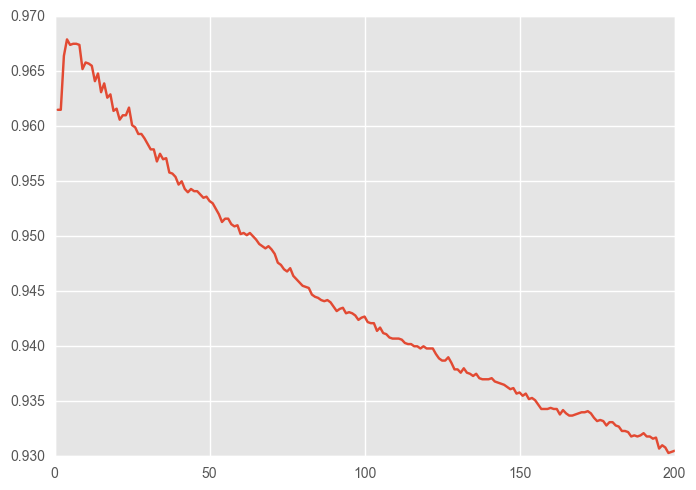

In [155]:

"""## Load prediciton list 
with open('data/' + "predictions_knn_{}_{}".format(emb_dim,emb_type) + '.pkl', 'rb') as f:
    predictions = pickle.load(f) """

## Calculate accuracy 
accuracy = list()
k_test=200
for k in range(1,k_test+1):
    sim_pred = sum(predictions[k] == emb_test[:,-1])
    accuracy.append((sim_pred/len(emb_test),k))
    
## Plotting accuracy (y_axis) vs K value (x_axis) curve
acc_k = [val[1] for val in accuracy]
acc_val = [val[0] for val in accuracy]

plt.plot(acc_k, acc_val)
plt.show()

In [156]:
idx = round(np.sqrt(60000/2)) # for k = sqrt(n/2)
print("Accuracy at {} = {}".format(idx, accuracy[int(idx-1)][0]))

Accuracy at 173.0 = 0.9339


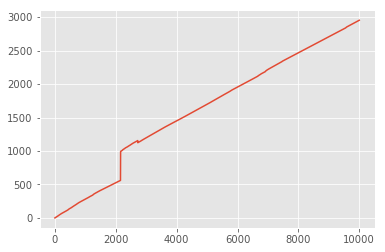

In [28]:
plt.plot(time_list)
plt.show()

In [ ]:
"""print(n)
    ## Calculate the distance of each test instance from train instances 
    test_inst = test_inst[:-1]
    test_inst = test_inst.reshape(1,-1)
    test_inst = test_inst.repeat(len(emb_train), axis=0)
    temp_dist = np.linalg.norm((test_inst - emb_train[:,:-1]), axis=1)

    ## Store distance and respective labels in tuples in a list
    temp_dist_idx = [(temp_dist[i],emb_train[i,-1]) for i in range(len(emb_train))]
    temp_dist_idx.sort()
"""

# CNN on Embeddings

**To use relevant indices, simply unpickle the list 'relevant_idx' and extract corresponding 
rows within the 'train_X' matrix**

In [131]:
def eucl_dist(instance, dataset):
    
    temp_inst = instance.reshape(1,-1)
    temp_inst = temp_inst.repeat(len(dataset), axis=0)
    eucl_dist = np.linalg.norm((temp_inst - dataset[:,:-2]), axis=1)
    eucl_dist_sorted = [(eucl_dist[i], dataset[i,-2]) for i in range(len(dataset))]
    eucl_dist_sorted.sort()
    
    return eucl_dist_sorted


## Removing the Bayesian Error

In [132]:
"""
- Remove Baysean error
    - Create 2 subsets
    - Find 1NN of instances from subset 1 using subset 2
        - classify them : Delete wrongly classified instances
    -  Find 1NN of instances from subset 2 using subset 1
        - classify them : Delete wrongly classified instances
    - Repeat until stability 
"""

## Adding indices to the embeddings (to keep track of them)
track_idx = np.array([i for i in range(len(emb))]).reshape(-1,1)
emb = np.concatenate((emb, track_idx), axis = 1)

## Creating subsets for CNN algo
train_subset_1 = emb[:30000]
train_subset_2 = emb[30000:60000]
track_unwanted = list() # store irrelevant indices

stability = False
prev_len_subset_1 = len(train_subset_1)
prev_len_subset_2 = len(train_subset_2)

itr = 0
while not stability:
    
    itr += 1
    print(itr)
    
    temp_unwanted = list()
    
    for n_1,sub_1 in enumerate(train_subset_1):
        
        
        eucl_dist_sorted = eucl_dist(sub_1[:-2], train_subset_2)
    
        ## Choose first k elements from sorted list 'temp_dist_idx'
        temp_first_nn = eucl_dist_sorted[0]
        temp_label = temp_first_nn[1]

        ## Store indices in unwated list if class is wrong
        if temp_label != sub_1[-2]:
            temp_unwanted.append(n_1)
            track_unwanted.append(sub_1[-1])
            
    ## Delete rows of train_subset_1 whose indices lie within the list 'temp_unwanted'  
    train_subset_1 = np.delete(train_subset_1, temp_unwanted, axis=0)
    
    ## Save train_subset_1
    np.save('data/train_subset_1_{}'.format(itr), train_subset_1)
    
    print(itr)
    
    temp_unwanted = list()
    
    for n_2,sub_2 in enumerate(train_subset_2):
        
        eucl_dist_sorted = eucl_dist(sub_2[:-2], train_subset_1)
        
        ## Choose first k elements from sorted list 'temp_dist_idx'
        temp_first_nn = eucl_dist_sorted[0]
        temp_label = temp_first_nn[1]
        
        ## Store indices in unwated list if class is wrong
        if temp_label != sub_2[-2]:
            temp_unwanted.append(n_2)
            track_unwanted.append(sub_2[-1])
            
    ## Delete rows of train_subset_1 whose indices lie within the list 'temp_unwanted'  
    train_subset_2 = np.delete(train_subset_2, temp_unwanted, axis=0)
            
    np.save('data/train_subset_2_{}'.format(itr), train_subset_2)
    
    if prev_len_subset_1 == len(train_subset_1) and prev_len_subset_2 == len(train_subset_2):
        stability = True
        
    else: 
        prev_len_subset_1 = len(train_subset_1)
        prev_len_subset_2 = len(train_subset_2)
      
        

1
1
2
2
3
3


In [133]:
train_subset_1 = np.load('data/train_subset_1_3.npy')
train_subset_2 = np.load('data/train_subset_2_3.npy')
print(train_subset_1.shape, train_subset_2.shape)

(28734, 198) (28932, 198)


## Condensed Nearest Neighbours

In [134]:
"""
- Remove instances that can be easily classified
    - Find 1NN neighbours of every instance with every other
    - if class of instance == class of other instance : Delete
    - elif class of instance != class of other instance : Keep
    
"""

## train_subset_1 union train_subset_2 
train_emb_bay = np.concatenate((train_subset_1,train_subset_2), axis = 0)

## Creating storage for relevant instances
random_idx = np.random.choice(len(train_emb_bay),1)
STORAGE = train_emb_bay[random_idx]

stability = False

prev_storage_len = len(STORAGE)
itr = 0 

while not stability:
    
    itr += 1
    print(itr)
    
    for inst in train_emb_bay:
        
        # Calc list sorted by ascending order of euc distance
        eucl_dist_sorted = eucl_dist(inst[:-2], STORAGE)
        
        # Choose first element from sorted list 'temp_dist_idx'
        temp_first_nn = eucl_dist_sorted[0]
        temp_label = temp_first_nn[1]
        
        # Store indices in unwated list if class is wrong
        if temp_label != inst[-2]:
            STORAGE = np.concatenate((STORAGE, inst.reshape(1,-1)), axis = 0)
        
        else:continue 
    
    #np.save('data/STORAGE_{}'.format(itr), STORAGE)

    if prev_storage_len == len(STORAGE):
        stability = True
    
    else:
        prev_storage_len = len(STORAGE)
        print(len(STORAGE))
        print(prev_storage_len)
            

1
3547
3547
2
4391
4391
3
4520
4520
4
4531
4531
5


In [135]:
#STORAGE = np.load('data/STORAGE_5.npy')
relevant_idx = list()
for i in range(len(STORAGE)):
    relevant_idx.append(STORAGE[i,-1])

## Store relevant indices 
with open("data/Final/relevant_idx_{}_{}".format(emb_dim, emb_type), "wb") as fp:   #Pickling
    pickle.dump(relevant_idx, fp)
    
"""## Load relevant indices
with open("relevant_idx", "rb") as fp:  
b = pickle.load(fp)"""

'## Load relevant indices\nwith open("relevant_idx", "rb") as fp:  \nb = pickle.load(fp)'

# KNN on strong examples (after CNN)

In [140]:
path = 'data/embeddings_{}_{}.npy'.format(emb_dim, emb_type)
emb = np.load(path)

## Load relevant examples
with open("data/Final/relevant_idx_{}_{}".format(emb_dim, emb_type), "rb") as fp:   # Unpickling
    relevant_idx = pickle.load(fp)
    
relevant_idx = [int(i) for i in relevant_idx]
emb_train = emb[relevant_idx]
emb_train.shape

(4531, 197)

In [137]:
"""
## To-Do
- Try the same on the only the MNIST datasets

- Decide on k values
- Calculate distance of each test instance with database and append to list
- Sort in descending order
- Pick the first 'k' values and assign test emb to majority clas
- Calculate the error

"""
def eucl_dist(instance, dataset):
    
    temp_inst = instance.reshape(1,-1)
    #temp_inst = temp_inst.repeat(len(dataset), axis=0)
    eucl_dist = np.linalg.norm((temp_inst - dataset[:,:-1]), axis=1)
    eucl_dist_sorted = [(eucl_dist[i], dataset[i,-1]) for i in range(len(dataset))]
    eucl_dist_sorted.sort()
    
    return eucl_dist_sorted


emb_test = emb[60000:]
k_test = 100

predictions = dict()
time_list = list()

start_time = time.time()

for k in range(1,k_test+1) : predictions[k] = list()

for n, test_inst in enumerate(emb_test):
    
    instance = test_inst[:-1] # remove the label
    temp_dist_idx = eucl_dist(instance, emb_train) # dataset = emb_train 

    for k in range(1,k_test+1):
    
        ## Choose first k elements from sorted list 'temp_dist_idx'
        temp_first_k = temp_dist_idx[:k]
        temp_labels = [digit[1] for digit in temp_first_k]

        ## Pick label that has majority count and append to prediction list
        temp_list = [temp_labels.count(i) for i in temp_labels]
        predictions[k].append(temp_labels[temp_list.index(max(temp_list))])

    time_list.append(round(time.time() - start_time, 3))
    print(n, time_list[-1])
        
## Pickling predictions and time values
path = "data/Final/"
with open(path + "predictions_knn_strong_{}_{}".format(emb_dim,emb_type) + '.pkl', 'wb') as f:
    pickle.dump(predictions, f, pickle.HIGHEST_PROTOCOL)
#with open(path + "time_knn_strong_{}_{}".format(emb_dim,emb_type) + '.pkl', 'wb') as f:
#    pickle.dump(time_list, f, pickle.HIGHEST_PROTOCOL)

0 0.045
1 0.068
2 0.09
3 0.111
4 0.132
5 0.153
6 0.174
7 0.195
8 0.217
9 0.237
10 0.26
11 0.283
12 0.305
13 0.326
14 0.346
15 0.366
16 0.387
17 0.409
18 0.431
19 0.452
20 0.474
21 0.495
22 0.516
23 0.538
24 0.56
25 0.58
26 0.6
27 0.622
28 0.642
29 0.663
30 0.685
31 0.708
32 0.728
33 0.749
34 0.769
35 0.791
36 0.811
37 0.832
38 0.853
39 0.873
40 0.894
41 0.915
42 0.937
43 0.957
44 0.977
45 0.997
46 1.018
47 1.041
48 1.062
49 1.082
50 1.104
51 1.126
52 1.147
53 1.168
54 1.188
55 1.208
56 1.228
57 1.249
58 1.273
59 1.295
60 1.316
61 1.338
62 1.359
63 1.38
64 1.401
65 1.422
66 1.443
67 1.464
68 1.484
69 1.506
70 1.527
71 1.549
72 1.575
73 1.596
74 1.617
75 1.637
76 1.658
77 1.68
78 1.702
79 1.722
80 1.743
81 1.764
82 1.785
83 1.806
84 1.827
85 1.848
86 1.869
87 1.89
88 1.911
89 1.932
90 1.955
91 1.976
92 1.997
93 2.018
94 2.039
95 2.06
96 2.08
97 2.101
98 2.122
99 2.143
100 2.164
101 2.185
102 2.206
103 2.23
104 2.251
105 2.272
106 2.294
107 2.315
108 2.338
109 2.36
110 2.382
111 2.405
112

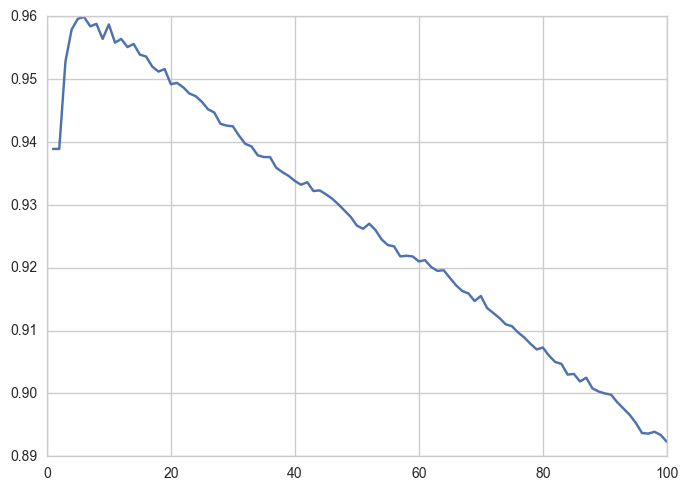

In [141]:
## Calculate accuracy 
accuracy = list()
for k in range(1,k_test+1):
    sim_pred = sum(predictions[k] == emb_test[:,-1])
    accuracy.append((sim_pred/len(emb_test),k))

## Plotting accuracy (y_axis) vs K value (x_axis) curve
acc_k = [val[1] for val in accuracy]
acc_val = [val[0] for val in accuracy]

plt.plot(acc_k, acc_val)
plt.show()

In [143]:
idx = int(round(np.sqrt(4531/2)))  # for k = sqrt(n/2)
print("Accuracy at {} = {}".format(idx, accuracy[idx-1][0]))

Accuracy at 48 = 0.9291


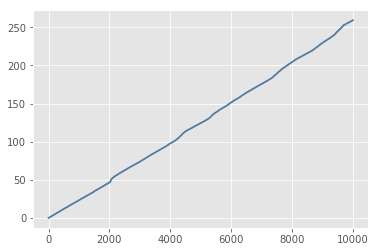

In [49]:
plt.plot(time_list)
plt.show()

# Metric Learning

## With Relevant Examples

In [52]:
## Load relevalant examples
with open("data/Final/relevant_idx_{}_{}".format(emb_dim, emb_type), "rb") as fp:   
    relevant_idx = pickle.load(fp)
    
relevant_idx = [int(i) for i in relevant_idx]
emb_train = emb[relevant_idx]
emb_train.shape

(4707, 197)

In [55]:
X = emb_train[:,:-1]
Y = emb_train[:,-1]

### LMNN

In [56]:
ls = [10, 20, 30, 40, 50, 60,70]
for i in ls:

    # setting up LMNN
    lmnn = metric_learn.LMNN(k=i, learn_rate=1e-2, verbose= True)

    # fit the data
    lmnn.fit(X, Y)

    # transform our input space
    X_lmnn = lmnn.transform()
    
    matrix_m = lmnn.metric()
    np.save('data/Final/matrix_m_{}'.format(i), matrix_m)

/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


2 806158.5297779104 -403186.48099118273 293854 4.931640625e-06
3 594212.3380995872 -211946.1916783232 324406 4.98095703125e-06
4 577612.8215703573 -16599.516529229935 337845 2.51538330078125e-06
5 577612.8215703573 0.0 337845 5.641125641695638e-22
6 577612.8215703573 0.0 337845 5.697536898112594e-22
7 577612.8215703573 0.0 337845 1.4386280667734302e-22
8 577612.8215703573 0.0 337845 1.4530143474411646e-22
9 577612.8215703573 0.0 337845 1.4675444909155761e-22
10 577612.8215703573 0.0 337845 1.482219935824732e-22
11 577612.8215703573 0.0 337845 1.4970421351829792e-22
12 577612.8215703573 0.0 337845 1.512012556534809e-22
13 577612.8215703573 0.0 337845 1.5271326821001572e-22
14 577612.8215703573 0.0 337845 1.5424040089211587e-22
15 577612.8215703573 0.0 337845 7.789140245051852e-23
16 577612.8215703573 0.0 337845 7.867031647502371e-23
17 577612.8215703573 0.0 337845 7.945701963977395e-23
18 577612.8215703573 0.0 337845 8.025158983617168e-23
19 577612.8215703573 0.0 337845 8.10541057345334

In [52]:
def eucl_dist_metric(instance, dataset, matrix_m):
    
    temp_inst = instance.reshape(1,-1)
    temp_inst = temp_inst.repeat(len(dataset), axis=0)
    difference = temp_inst - dataset[:,:-1]
    eucl_dist = np.diag(np.sqrt(np.matmul(np.matmul(difference, matrix_m),difference.T)))
    eucl_dist_sorted = [(eucl_dist[i], dataset[i,-1]) for i in range(len(dataset))]
    eucl_dist_sorted.sort()
    
    return eucl_dist_sorted


In [ ]:
"""
## To-Do
- Try the same on the only the MNIST datasets

- Decide on k values
- Calculate distance of each test instance with database and append to list
- Sort in descending order
- Pick the first 'k' values and assign test emb to majority clas
- Calculate the error

"""

def eucl_dist_metric(instance, dataset, matrix_m):
    
    temp_inst = instance.reshape(1,-1)
    temp_inst = temp_inst.repeat(len(dataset), axis=0)
    difference = temp_inst - dataset[:,:-1]
    eucl_dist = np.diag(np.sqrt(np.matmul(np.matmul(difference, matrix_m),difference.T)))
    eucl_dist_sorted = [(eucl_dist[i], dataset[i,-1]) for i in range(len(dataset))]
    eucl_dist_sorted.sort()
    
    return eucl_dist_sorted

ls = [20, 30, 40, 50, 60,70]

for i in ls:
    
    matrix_m = np.load('data/Final/matrix_m_{}.npy'.format(i))
    
    emb_test = emb[60000:]
    k_test = 100
    
    predictions = dict()
    time_list = list()

    for k in range(1,k_test+1) : predictions[k] = list()

    start_time = time.time()
    for n, test_inst in enumerate(emb_test):
        
        ## Calculate the distance of each test instance from train instances 
        eucl_dist_sorted = eucl_dist_metric(test_inst[:-1], emb_train, matrix_m)

        for k in range(1,k_test+1):

            ## Choose first k elements from sorted list 'temp_dist_idx'
            temp_first_k = eucl_dist_sorted[:k]
            temp_labels = [digit[1] for digit in temp_first_k]

            ## Pick label that has majority count and append to prediction list
            temp_list = [temp_labels.count(i) for i in temp_labels]
            predictions[k].append(temp_labels[temp_list.index(max(temp_list))])
    
        time_list.append(round(time.time() - start_time))
        print(n,time_list[-1])
        
    ## Pickling predictions and time values
    path = "data/Final/"
    with open(path + "predictions_knn_strong_metric_{}_{}_{}".format(emb_dim,emb_type,i) + '.pkl', 'wb') as f:
        pickle.dump(predictions, f, pickle.HIGHEST_PROTOCOL)
    with open(path + "time_knn_strong_metric_{}_{}_{}".format(emb_dim,emb_type,i) + '.pkl', 'wb') as f:
        pickle.dump(time_list, f, pickle.HIGHEST_PROTOCOL)

/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in sqrt


0 1
1 2
2 3
3 4
4 5
5 5
6 6
7 7
8 8
9 9
10 10
11 10
12 11
13 12
14 13
15 14
16 15
17 16
18 17
19 18
20 19
21 20
22 21
23 22
24 23
25 24
26 25
27 26
28 27
29 27
30 28
31 29
32 31
33 32
34 33
35 34
36 35
37 36
38 37
39 38
40 39
41 40
42 41
43 42
44 43
45 43
46 45
47 45
48 46
49 47
50 48
51 49
52 50
53 50
54 52
55 53
56 54
57 55
58 56
59 57
60 58
61 59
62 60
63 61
64 62
65 63
66 64
67 65
68 66
69 67
70 68
71 69
72 70
73 71
74 72
75 73
76 74
77 75
78 77
79 78
80 79
81 80
82 81
83 82
84 84
85 85
86 86
87 86
88 87
89 88
90 89
91 90
92 91
93 92
94 93
95 94
96 95
97 96
98 97
99 98
100 99
101 100
102 101
103 102
104 103
105 104
106 105
107 106
108 107
109 108
110 108
111 109
112 110
113 111
114 112
115 113
116 114
117 115
118 116
119 117
120 118
121 119
122 120
123 121
124 121
125 123
126 124
127 125
128 125
129 126
130 127
131 128
132 129
133 130
134 131
135 132
136 133
137 134
138 135
139 136
140 137
141 138
142 139
143 140
144 141
145 142
146 143
147 144
148 145
149 146
150 147
151 148
152 1

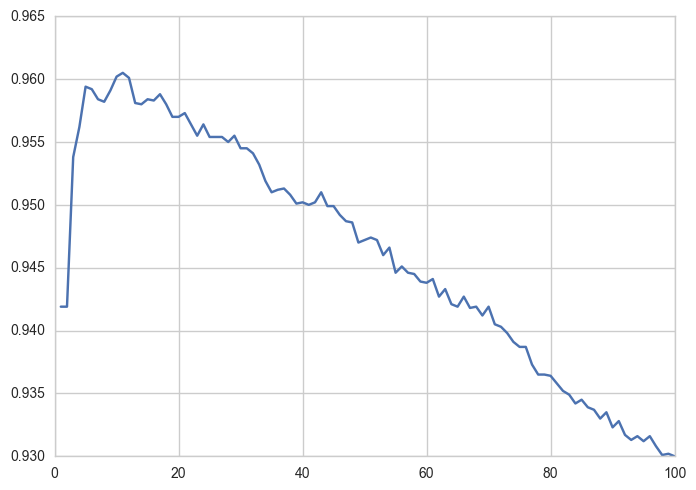

In [105]:
i = 30
name = "data/Final/predictions_knn_strong_metric_{}_{}_{}".format(emb_dim,emb_type,i)
with open(name + '.pkl', 'rb') as f:
    predictions = pickle.load(f)

## Calculate accuracy 
accuracy = list()
for k in range(1,100+1):
    sim_pred = sum(predictions[k] == emb_test[:,-1])
    accuracy.append((sim_pred/len(emb_test),k))
    
## Plotting accuracy (y_axis) vs K value (x_axis) curve
acc_k = [val[1] for val in accuracy]
acc_val = [val[0] for val in accuracy]

plt.plot(acc_k, acc_val)
plt.show()

In [106]:
idx = int(round(np.sqrt(4707/2)))  # for k = sqrt(n/2)
print("Accuracy at {} = {}".format(idx, accuracy[idx-1][0]))

Accuracy at 49 = 0.947


In [ ]:
0.9356 0.9345 0.947 0.9425 0.9437 0.9454 0.9317

### ITML

In [42]:
itml = metric_learn.ITML_Supervised(num_constraints=200)
X_itml = itml.fit_transform(X, Y)

In [43]:
"""
## To-Do
- Try the same on the only the MNIST datasets

- Decide on k values
- Calculate distance of each test instance with database and append to list
- Sort in descending order
- Pick the first 'k' values and assign test emb to majority clas
- Calculate the error

"""
#emb_train = emb[idx[:60000]]
emb_test = emb[60000:61000]
#emb_test = emb_train
k_test = 100
predictions = dict()

for k in range(1,k_test+1) : predictions[k] = list()

for n, test_inst in enumerate(emb_test):
    print(n)
    ## Calculate the distance of each test instance from train instances 
    test_inst = test_inst[:-1]
    test_inst = test_inst.reshape(1,-1)
    test_inst = test_inst.repeat(len(X_itml), axis=0)
    temp_dist = np.linalg.norm((test_inst - X_itml), axis=1)

    ## Store distance and respective labels in tuples in a list
    temp_dist_idx = [(temp_dist[i],emb_train[i,-1]) for i in range(len(X_itml))]
    temp_dist_idx.sort()

    for k in range(1,k_test+1):
    
        ## Choose first k elements from sorted list 'temp_dist_idx'
        temp_first_k = temp_dist_idx[:k]
        temp_labels = [digit[1] for digit in temp_first_k]

        ## Pick label that has majority count and append to prediction list
        temp_list = [temp_labels.count(i) for i in temp_labels]
        predictions[k].append(temp_labels[temp_list.index(max(temp_list))])

#name = "predictions_knn_cnn_metric"
#with open(name + '.pkl', 'wb') as f:
#    pickle.dump(predictions, f, pickle.HIGHEST_PROTOCOL)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

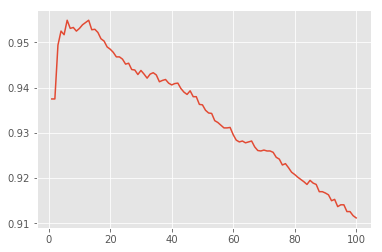

In [56]:
"""
name = "predictions_knn_cnn_metric"
with open(name + '.pkl', 'rb') as f:
    predictions = pickle.load(f)
"""
## Calculate accuracy 
accuracy = list()
for k in range(1,k_test+1):
    sim_pred = sum(predictions[k] == emb_test[:,-1])
    accuracy.append((sim_pred/len(emb_test),k))
    
## Plotting accuracy (y_axis) vs K value (x_axis) curve
acc_k = [val[1] for val in accuracy]
acc_val = [val[0] for val in accuracy]

plt.plot(acc_k, acc_val)
plt.show()

In [57]:
idx = int(round(np.sqrt(5000/2)))  # for k = sqrt(n/2)
print("Accuracy at {} = {}".format(idx, accuracy[idx-1][0]))

Accuracy at 50 = 0.9362


# PLOTS

In [9]:
 #print(plt.style.available)
style.use('seaborn-white')
base_path = 'data/Final/'
emb_test = emb[60000:]

In [20]:
def accuracy(predictions, k_test, acc = 49):
    
    accuracy = list()
    for k in range(1,k_test+1):
        sim_pred = sum(predictions[k] == emb_test[:,-1])
        accuracy.append((sim_pred/len(emb_test),k))
    
    ## Plotting accuracy (y_axis) vs K value (x_axis) curve
    acc_k = [val[1] for val in accuracy]
    acc_val = [val[0] for val in accuracy]
    return acc_k, acc_val
    #plt.plot(acc_k, acc_val)
    #plt.show()
      
    # for k = sqrt(n/2)
    #print("Accuracy at {} = {}".format(acc, accuracy[acc-1][0]))
    
    

## KNN ALL and STRONG examples

In [21]:
with open(base_path + 'predictions_knn_197_n.pkl', 'rb') as f:
    knn_all_pred = pickle.load(f) 
all_k_vals, all_acc_vals = accuracy(knn_all_pred, 200, 173)

with open(base_path + 'predictions_knn_strong_197_n.pkl', 'rb') as f:
    knn_strong_pred = pickle.load(f) 
str_k_vals, str_acc_vals =  accuracy(knn_strong_pred, 100)

In [30]:
with open(base_path + 'time_knn_197_n.pkl', 'rb') as f:
    time_all = pickle.load(f) 
with open(base_path + 'time_knn_strong_197_n.pkl', 'rb') as f:
    time_strong = pickle.load(f) 


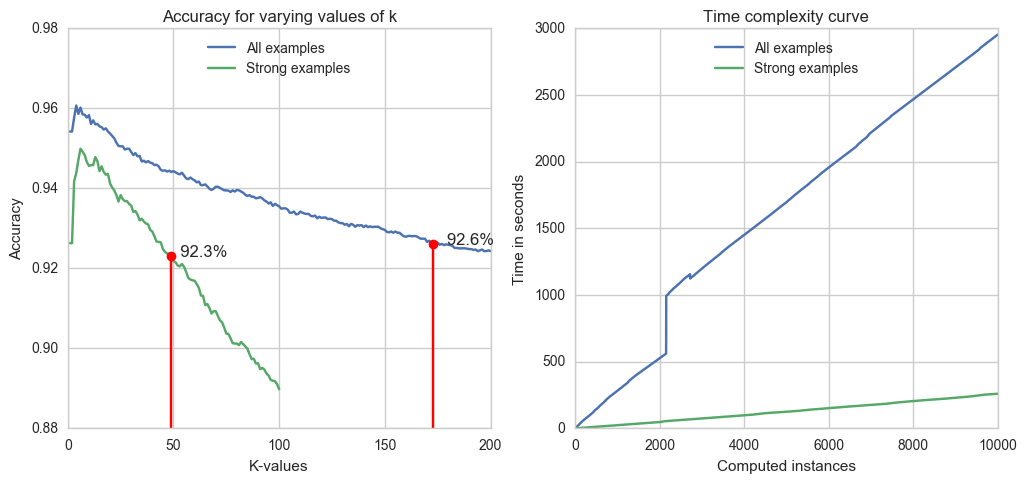

In [124]:
plt.figure(figsize= (12,5))
style.use('seaborn-whitegrid')
plot_dict = {'accuracy': ['Accuracy for varying values of k', 'K-values', 'Accuracy', ['All examples', 'Strong examples']],
             'time': ['Time complexity curve', 'Computed instances', 'Time in seconds', ['All examples', 'Strong examples']]}

metrics = ['accuracy','time']
metric_dict = dict() 
metric_dict['accuracy'] = [(all_k_vals, all_acc_vals),(str_k_vals, str_acc_vals)]
x_range = [i for i in range(len(time_all))]
metric_dict['time'] = [(x_range,time_all), (x_range,time_strong)]


for n,item in enumerate(metrics):
    
    title, x_axis, y_axis, lengend = plot_dict[metrics[n]]
    temp = metric_dict[item]
    
    plt.subplot(1, 2, n+1)
    plt.title(title)
    for plot in temp:
        plt.plot(plot[0], plot[1])
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend(lengend, loc='upper center')
    if not n:
        plt.plot([49,49],[0.88,0.923], 'r')
        plt.text(49, 0.923, '  92.3%')
        plt.plot(49, 0.923,'ro') 
        plt.plot([173,173],[0.88,0.926], 'r')
        plt.text(173, 0.926, '   92.6%')
        plt.plot(173, 0.926,'ro') 


plt.savefig('All_vs_strong.png')
plt.show()

In [63]:
ls = [i for i in range(10,80,10)]
acc_dict = dict()
time_dict = dict()

for i in ls:
    with open(base_path + 'predictions_knn_strong_metric_197_n_{}.pkl'.format(i), 'rb') as f:
        temp_pred = pickle.load(f) 
    acc_dict[i] = accuracy(temp_pred, 100)

    with open(base_path + 'time_knn_strong_metric_197_n_{}.pkl'.format(i), 'rb') as f:
        time_dict[i] = pickle.load(f) 


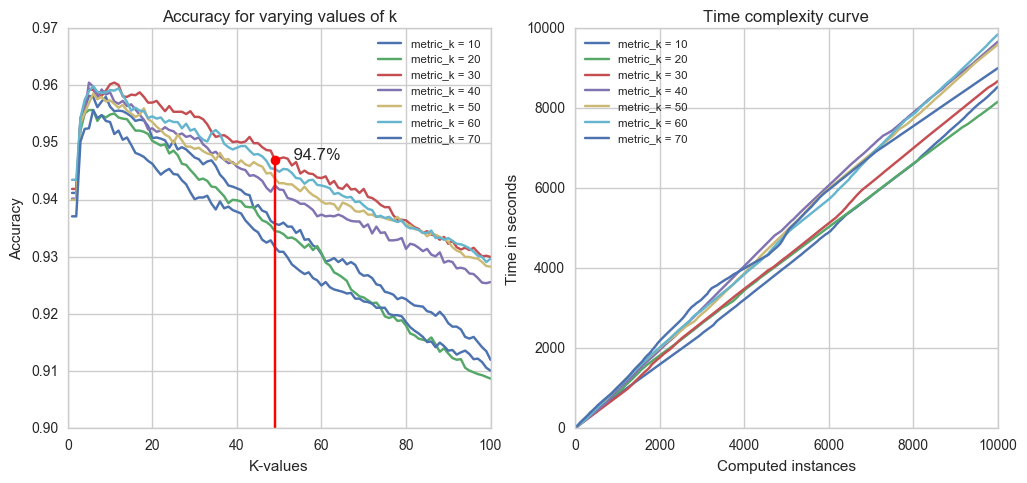

In [121]:
plt.figure(figsize= (12,5))
style.use('seaborn-whitegrid')
plot_dict = {'accuracy': ['Accuracy for varying values of k', 'K-values', 'Accuracy', 
                          ['metric_k = {}'.format(i) for i in ls]],
             'time': ['Time complexity curve', 'Computed instances', 'Time in seconds', 
                      ['metric_k = {}'.format(i) for i in ls]]}

metrics = ['accuracy','time']
metric_dict = dict() 
metric_dict['accuracy'] = [i[1] for i in acc_dict.items()]
x_range = [i for i in range(len(time_all))]
metric_dict['time'] = [(x_range,i[1]) for i in time_dict.items()]


for n,item in enumerate(metrics):
    
    title, x_axis, y_axis, lengend = plot_dict[metrics[n]]
    temp = metric_dict[item]
    
    plt.subplot(1, 2, n+1)
    plt.title(title)
    for plot in temp:
        plt.plot(plot[0], plot[1])
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    if not n: plt.legend(lengend, loc='upper right', fontsize ='x-small')   
    else: plt.legend(lengend, loc='upper left', fontsize ='x-small')
    
    if not n:
        plt.plot([49,49],[0.90,0.947], 'r')
        plt.text(49, 0.947, '    94.7%',)
        plt.plot(49, 0.947,'ro') 
    
plt.savefig('metric_strong.png')     
plt.show()